In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader

# Please install the required library using command pip install torch/<library_name>


torch.manual_seed(100) # To reproduce results freeze a seed

In [2]:
# Disc: Please feel rewrite the entire on your own if you find any issues
# Set up the compute device: CPU or Cuda, if you have multiple GPUs, you can choose one using <cuda:0> or
# <cuda:1>
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# Generate training samples
K=500 # number of samples
X1=np.linspace(-1,1,K)  
X2=np.linspace(-1,1,K)  
X3=np.linspace(-1,1,K)  
X4=np.linspace(-1,1,K)  

# Generate test samples
T=50

#make the union of (-2,-1)U(1,2)
t1=np.linspace(-2,-1,25)
t2=np.linspace(1,2,25)
t3=np.append(t1,t2)
X1_test,X2_test,X3_test,X4_test=t3,t3,t3,t3
# Create input feature vector
Features=[[X1[i],X2[i],X3[i],X4[i]]for i in range(K)]
Features_test=[[X1_test[i],X2_test[i],X3_test[i],X4_test[i]]for i in range(T)]
# Target cubic function (poly of degree 3)
Q_function=[  (X1[i]**2) +  (X2[i]**2)  +  2*(X3[i]**3)  +  4*(X4[i]**3)  for i in range(K)]

# Adding noise to training samples
mu, sigma = 0, np.sqrt(0.001)
noise=np.random.normal(mu,sigma,np.shape(Q_function))

Q_function=Q_function+noise

Q_function_test=[ (X1_test[i]**2) +  (X2_test[i]**2)  +  2*(X3_test[i]**3)  +  4*(X4_test[i]**3)  for i in range(T)]

Output=torch.as_tensor(Q_function,dtype=torch.float32,device=device)
Input=torch.as_tensor(Features,dtype=torch.float32,device=device)

Output_test=torch.as_tensor(Q_function_test,dtype=torch.float32,device=device)
Input_test=torch.as_tensor(Features_test,dtype=torch.float32,device=device)

Model_Parameters = []
Model_Testing_Performance = []
Model_Training_Performance = []
num_epochs = 25

In [ ]:
len(Q_function)

In [ ]:
np.mean([i**2 for i in Q_function_test])

In [ ]:
np.mean([i**2 for i in Q_function])

In [4]:
# A function to count the number of parameters of a network
def parameters(model):
    all_parameters=list(model.parameters())
    layer_parameters=[len(i) for i in all_parameters] 
    print(layer_parameters) 

    # we have layer weights, followed by biases
    # sum up list 
    print("Total number of parameters in the network",sum(layer_parameters))
    return sum(layer_parameters)


In [6]:
# let's write a function that takes num_of_epochs, input, target as arguments
# returns loss

def training_network(num_epochs,model):
    
    #setup for batching
    
    epoch_loss_trace=[]
    epoch_testloss_trace=[]
    
    for layer in model.children():
         if hasattr(layer,"reset_parameters"):
             layer.reset_parameters()

    loss_fn=nn.MSELoss()
    optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=.9)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    for epoch in range(num_epochs):
        idx=torch.randperm(Input.size()[0])
        Input_shuffled=Input[idx,:] # Randomize inputs\n",
        Output_shuffled=Output[idx] # Randomize outputs\n",
        loss_accumulation=0
        testloss_accumulation=0
        for i in range(K):
            optimizer.zero_grad()
            predict=model(Input_shuffled[i])
            loss=loss_fn(predict,Output_shuffled[i]) # Calculates loss
            #print(predict,Output_shuffled[i])
            loss.backward() # Performs gradient descent
            optimizer.step() # Updates weights    
            loss_accumulation+=loss.item()#*training_input.size(0) # Stores loss weighted by batch size
        epoch_loss_trace.append((loss_accumulation)/K)
        #print("epoch:",epoch,"loss",epoch_loss_trace[epoch])
        testloss_accumulation=[loss_fn(model(Input_test[j]),Output_test[j]).item() for j in range(T)]
        epoch_testloss_trace.append(np.mean(testloss_accumulation))
        scheduler.step() # Schedules learning rate
    return epoch_loss_trace,epoch_testloss_trace

In [7]:
def plot_loss(train_loss,test_loss,num_params):
    fig,(ax1,ax2)=plt.subplots(2, figsize=(8, 8))
    ax1.plot(train_loss)
    ax1.set_title(f"Training loss over episodes, Parameters {num_params}")
    ax1.set_ylabel("Loss")
    #ax1.set_xlabel("Episodes")
    ax1.grid()
    ax2.plot(test_loss)
    ax2.set_title(f"Test loss over episodes, Parameters {num_params}")
    ax2.set_ylabel("Loss")
    ax2.set_xlabel("Episodes")
    ax2.grid()

In [8]:
class smallNetwork(nn.Module):
    def __init__(self) -> None:
        
        super().__init__() 
        self.flatten = nn.Flatten()
        self.fc1=nn.Linear(4,14) # We have input with 2 features
        self.fc2=nn.Linear(14,4) # Output and input of next fully connected layer must match
        self.fc3=nn.Linear(4,1) # Output of fc2 and input of fc3 must match
    def forward(self,f_hat):
        f_hat = F.sigmoid(self.fc1(f_hat))
        f_hat = F.leaky_relu(self.fc2(f_hat))
        f_hat = self.fc3(f_hat)
        return f_hat
    
smallNetwork_instance=smallNetwork().to(device)


In [9]:
smallNetwork_loss_trace,smallNetwork_testloss_trace=training_network(num_epochs,smallNetwork_instance)
Model_Training_Performance.append(smallNetwork_loss_trace[num_epochs-1])
Model_Testing_Performance.append(smallNetwork_testloss_trace[num_epochs-1])
Model_Parameters.append(parameters(smallNetwork_instance))

/home/grads/s/sant1/Desktop/simple_nn/simple_nn/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[14, 14, 4, 4, 1, 1]
Total number of parameters in the network 38


[14, 14, 4, 4, 1, 1]
Total number of parameters in the network 38


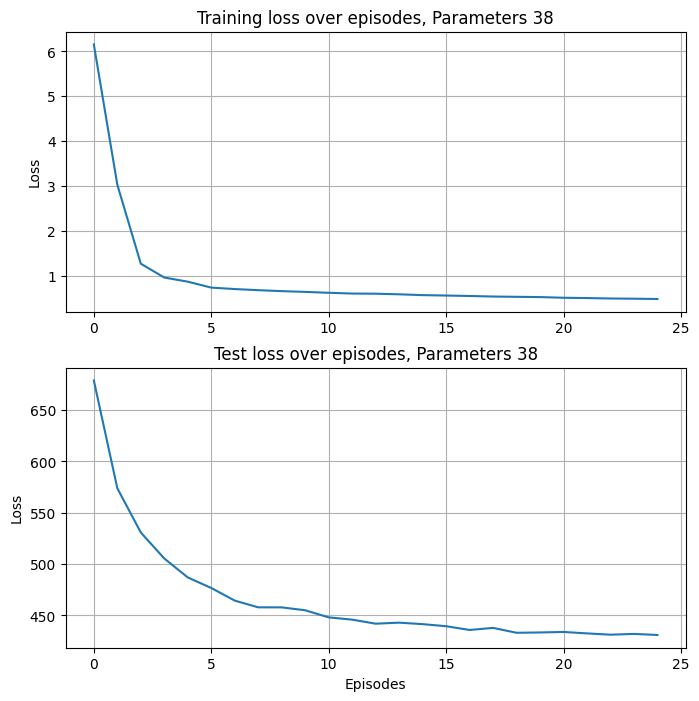

In [10]:
plot_loss(smallNetwork_loss_trace,smallNetwork_testloss_trace,parameters(smallNetwork_instance))

In [11]:
# We can write a neural network as a stack of neural layers
class smallNetStack(nn.Module):
    def __init__(self) -> None:
        
        super().__init__() 
        self.flatten = nn.Flatten()
        self.network_stack= nn.Sequential(
        nn.Linear(4,2),
        nn.ReLU(),
        nn.Linear(2,4),
        nn.LeakyReLU(), # output and input of next fully connected must match
        nn.Linear(4,1)) # output and final layer must match
    def forward(self,f_hat):
        f_hat = self.network_stack(f_hat)
        return f_hat
    
smallNetStack_instance=smallNetStack().to(device)

smallNetStack_loss_trace,smallNetStack_testloss_trace=training_network(num_epochs,smallNetStack_instance)
Model_Training_Performance.append(smallNetStack_loss_trace[num_epochs-1])
Model_Testing_Performance.append(smallNetStack_testloss_trace[num_epochs-1])
Model_Parameters.append(parameters(smallNetStack_instance))

[2, 2, 4, 4, 1, 1]
Total number of parameters in the network 14


[2, 2, 4, 4, 1, 1]
Total number of parameters in the network 14


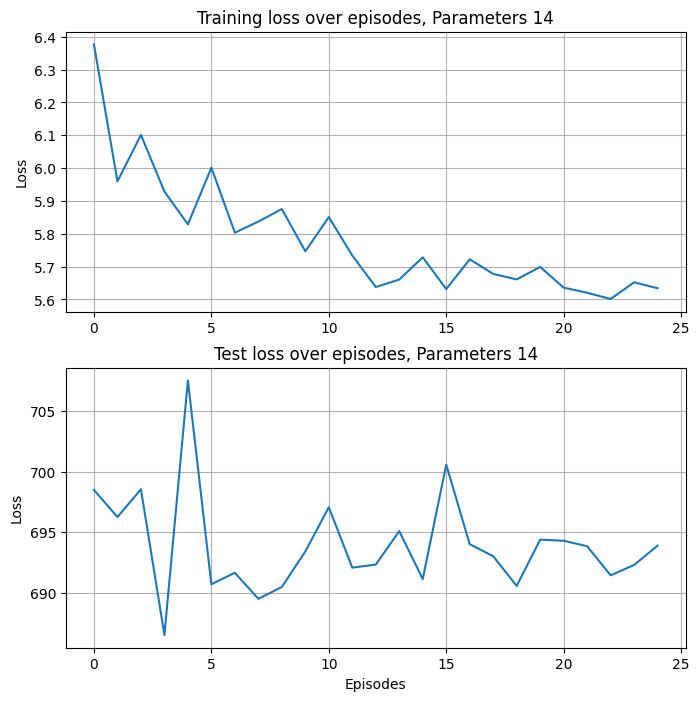

In [14]:
plot_loss(smallNetStack_loss_trace,smallNetStack_testloss_trace,parameters(smallNetStack_instance))

In [13]:
# Let's create a network with more parameters
class mediumNetwork(nn.Module):
    def __init__(self) -> None:
        
        super().__init__() # what's the use this
        self.flatten = nn.Flatten()
        self.network_stack= nn.Sequential(
        nn.Linear(4,80),
        nn.LeakyReLU(),        # output and input of next fully connected must match
        nn.Linear(80,20),
        nn.ReLU(),        # output and input of next fully connected must match
        nn.Linear(20,1)) # output and final layer must match
    def forward(self,f_hat):
        f_hat = self.network_stack(f_hat)
        return f_hat

mediumNet=mediumNetwork().to(device)

mediumNet_loss_trace,mediumNet_testloss_trace=training_network(num_epochs,mediumNet)
Model_Training_Performance.append(mediumNet_loss_trace[num_epochs-1])
Model_Testing_Performance.append(mediumNet_testloss_trace[num_epochs-1])
Model_Parameters.append(parameters(mediumNet))

[80, 80, 20, 20, 1, 1]
Total number of parameters in the network 202


[80, 80, 20, 20, 1, 1]
Total number of parameters in the network 202


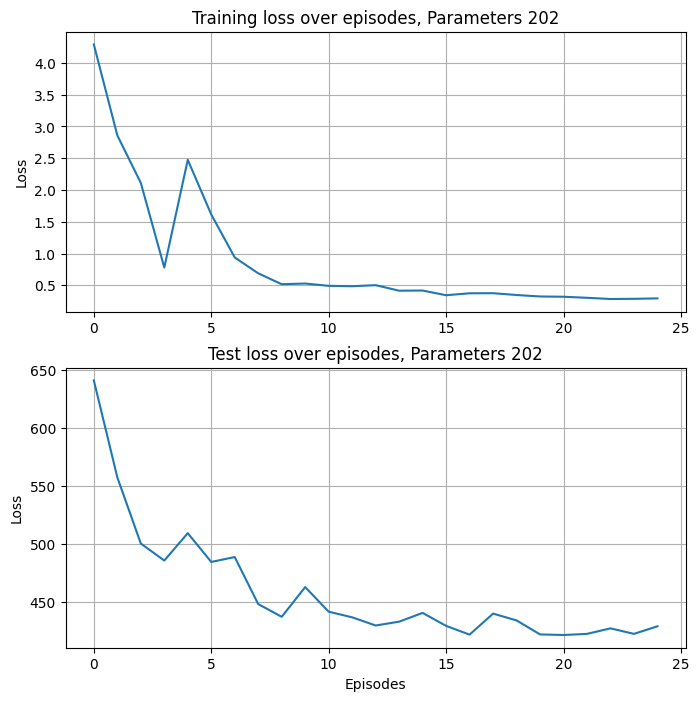

In [15]:
plot_loss(mediumNet_loss_trace,mediumNet_testloss_trace,parameters(mediumNet))

In [16]:
class largeNetwork(nn.Module):
    def __init__(self) -> None:
        
        super().__init__() 
        self.flatten = nn.Flatten()
        self.network_stack= nn.Sequential(
        nn.Linear(4,10),
        nn.ReLU(),
        nn.Linear(10,80),
        nn.LeakyReLU(),
        nn.Linear(80,400),
        nn.Sigmoid(), 
        nn.Linear(400,250),
        nn.LeakyReLU(),
        nn.Linear(250,10),
        nn.LeakyReLU(),                   
        nn.Linear(10,1)) 
    def forward(self,f_hat):
        f_hat = self.network_stack(f_hat)
        return f_hat
    
largeNet1=largeNetwork().to(device)
largeNet_loss_trace,largeNet_testloss_trace=training_network(num_epochs,largeNet1)
Model_Training_Performance.append(largeNet_loss_trace[num_epochs-1])
Model_Testing_Performance.append(largeNet_testloss_trace[num_epochs-1])
Model_Parameters.append(parameters(largeNet1))

[10, 10, 80, 80, 400, 400, 250, 250, 10, 10, 1, 1]
Total number of parameters in the network 1502


[10, 10, 80, 80, 400, 400, 250, 250, 10, 10, 1, 1]
Total number of parameters in the network 1502


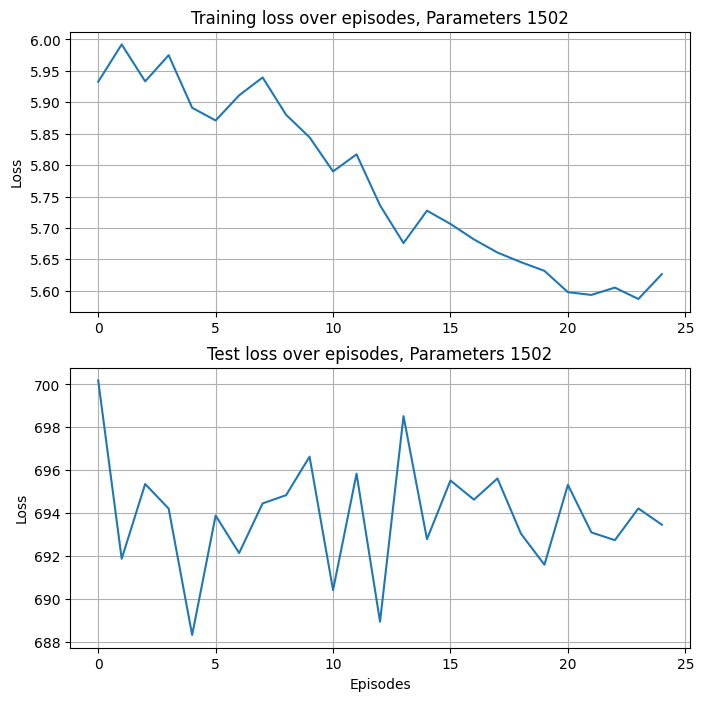

In [17]:
plot_loss(largeNet_loss_trace,largeNet_testloss_trace,parameters(largeNet1))

In [21]:
class largerNetwork2(nn.Module):
    def __init__(self) -> None:
        
        super().__init__() # what's the use this
        self.flatten = nn.Flatten()
        self.network_stack= nn.Sequential(
        nn.Linear(4,10),
        nn.ReLU(),
        nn.Linear(10,900),
        nn.LeakyReLU(),
        nn.Linear(900,1000),
        nn.LeakyReLU(), 
        nn.Linear(1000,500),
        nn.Sigmoid(),
        nn.Linear(500,500),
        nn.LeakyReLU(),                   # output and input of next fully connected must match
        nn.Linear(500,1)) # output and final layer must match
    def forward(self,f_hat):
        f_hat = self.network_stack(f_hat)
        return f_hat
    
largeNet2=largerNetwork2().to(device)
largeNet_loss_trace,largeNet_testloss_trace=training_network(num_epochs,largeNet2)
Model_Training_Performance.append(largeNet_loss_trace[num_epochs-1])
Model_Testing_Performance.append(largeNet_testloss_trace[num_epochs-1])
Model_Parameters.append(parameters(largeNet2))

[10, 10, 900, 900, 1000, 1000, 500, 500, 500, 500, 1, 1]
Total number of parameters in the network 5822


In [22]:
largeNet_loss_trace

[2.332996000717674,
 0.37535983890889973,
 0.2171209950990499,
 0.3247119245096196,
 0.12313300093810771,
 0.054992349901653144,
 0.03216808198624357,
 0.02052071889527052,
 0.012597432839754254,
 0.010618099970231115,
 0.008313716436605688,
 0.007251014798210804,
 0.007261218546380981,
 0.005845326084894138,
 0.004817752732416269,
 0.0031264200313829943,
 0.0030615344843760396,
 0.003110474873459511,
 0.003114917980138358,
 0.0029600024621023345,
 0.002622847618435486,
 0.002460010826851189,
 0.0022257679095059792,
 0.0022150360602545957,
 0.0020942262100160287]

[10, 10, 900, 900, 1000, 1000, 500, 500, 500, 500, 1, 1]
Total number of parameters in the network 5822


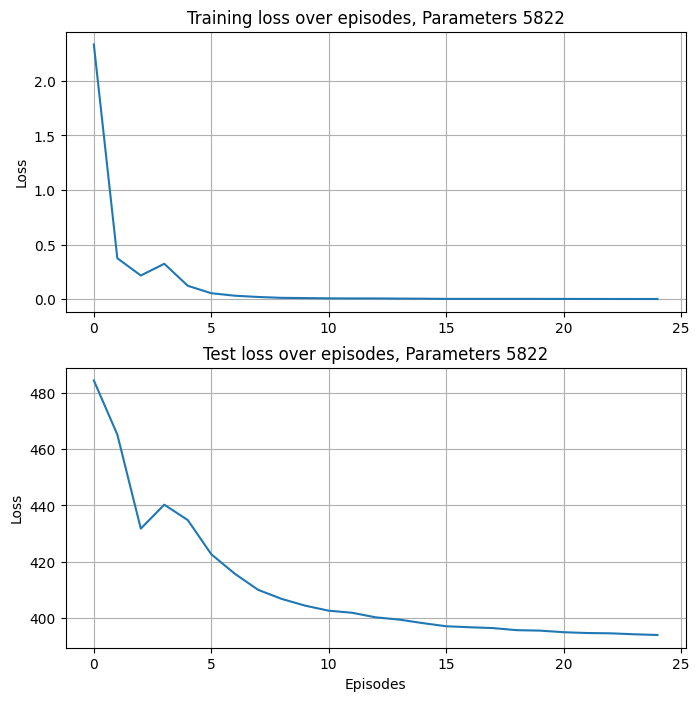

In [23]:
plot_loss(largeNet_loss_trace,largeNet_testloss_trace,parameters(largeNet2))

In [ ]:
# use this test network to explore double descent parameters
class test(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.network_stack= nn.Sequential(
        nn.Linear(4,50),
        
        nn.ReLU(),
        nn.Linear(50,15),
        nn.ReLU(),                   # output and input of next fully connected must match
        nn.Linear(15,1)) # output and final layer must match
    def forward(self,f_hat):
        f_hat = self.network_stack(f_hat)
        return f_hat
    
testNet=test().to(device)
testNet_loss_trace,testNet_testloss_trace=training_network(num_epochs,testNet,Input,Output,Input_test,Output_test)
Model_Training_Performance.append(testNet_loss_trace[num_epochs-1])
Model_Testing_Performance.append(testNet_testloss_trace[num_epochs-1])
plot_loss(testNet_loss_trace,testNet_testloss_trace,parameters(testNet))

In [28]:
x=Model_Testing_Performance[0]
Model_Testing_Performance[0]=Model_Testing_Performance[1]
Model_Testing_Performance[1]=x

<bound method _AxesBase.grid of <Axes: title={'center': 'Double Descent of Neural Networks'}, xlabel='Parameters', ylabel='Testing Loss'>>

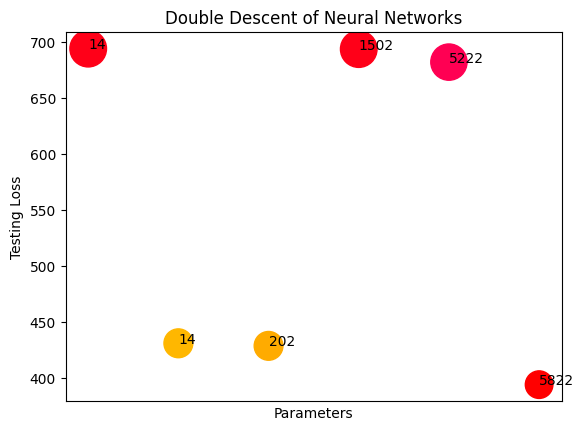

In [29]:
# Double Descent
fig,ax=plt.subplots()
colors=Model_Testing_Performance
ax.scatter(np.arange(len(Model_Testing_Performance)),Model_Testing_Performance,c=colors,cmap='hsv',s=np.dot(1,Model_Testing_Performance))
for i in range(len(Model_Parameters)):
    ax.annotate(Model_Parameters[i],(i,Model_Testing_Performance[i]))
ax.set_title("Double Descent of Neural Networks")
ax.set_ylabel("Testing Loss")
ax.set_xlabel("Parameters")
ax.set_xticks([])
ax.grid